In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RSEED = 42

*About*

Files available for download

* Train.csv - the training file
* Test.csv - the test file
* SampleSubmission.csv - is an example of what your submission file should look like. The order of the rows does not matter, but the names of the IDs must be correct. The column "target" is your prediction.

*Variable definitions*

* DATOP - Date of flight
* FLTID - Flight number
* DEPSTN - Departure point
* ARRSTN - Arrival point
* STD - Scheduled Time departure
* STA - Scheduled Time arrival
* STATUS - Flight status
* ETD - Expected Time departure
* ETA - Expected Time arrival
* ATD - Actual Time of Departure
* ATA - Actual Time of arrival
* DELAY1 - Delay code 1
* DUR1 - delay time 1
* DELAY2 - Delay code 2
* DUR2 - delay time 2
* DELAY3 - Delay code 3
* DUR3 - delay time 3
* DELAY4 - Delay code 4
* DUR4 - delay time 4
* AC - Aircraft Code


In [7]:
df = pd.read_csv("data/Train.csv", parse_dates=[1, 5])
# Column number 6 needs special treatment, since the data format is uncommon

In [8]:
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [9]:
df["STA"] = pd.to_datetime(df["STA"], format='%Y-%m-%d %H.%M.%S')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      107833 non-null  object        
 1   DATOP   107833 non-null  datetime64[ns]
 2   FLTID   107833 non-null  object        
 3   DEPSTN  107833 non-null  object        
 4   ARRSTN  107833 non-null  object        
 5   STD     107833 non-null  datetime64[ns]
 6   STA     107833 non-null  datetime64[ns]
 7   STATUS  107833 non-null  object        
 8   AC      107833 non-null  object        
 9   target  107833 non-null  float64       
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 8.2+ MB


In [11]:
# So: No missing values

Save the data to csv so it can be used in the airport weather script.

After that the eda can begin.

In [5]:
df.to_csv("data/sanitized_Train_data.csv", header=True, index=False)

---

### EDA

In [7]:
target = df["target"]
target.head()

0    260.0
1     20.0
2      0.0
3      0.0
4     22.0
Name: target, dtype: float64

<AxesSubplot:>

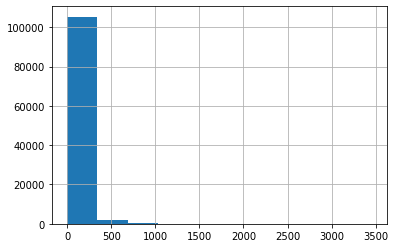

In [8]:
target.hist()

In [9]:
df.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


In [10]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target'],
      dtype='object')

In [11]:
df["target"].nunique()

968

Possible influences on delay:
- weekday
- time of day of departure
- before public holidays (?)
- weather (at departure / arrival location. weather in wider region)

In [12]:
df["ARRSTN"].value_counts().head(5)

TUN    42572
DJE    10198
ORY     6755
MIR     5251
MRS     2845
Name: ARRSTN, dtype: int64

In [13]:
df_num_delay = pd.DataFrame(df.groupby("ARRSTN").count()["target"])
df_num_delay.columns = ["number"]
df_num_delay

,number
ARRSTN,
AAE,1
ABJ,823
ADB,1
AHU,50
ALG,1573
...,...
VNO,6
VOG,2
VRN,27


In [14]:
df_num_delay["mean_delay"] = df.groupby("ARRSTN").mean()["target"]
df_num_delay.sort_values("number", ascending=False, inplace=True)
df_num_delay.head(5)

,number,mean_delay
ARRSTN,,
TUN,42572,50.364629
DJE,10198,35.229555
ORY,6755,41.913101
MIR,5251,42.422396
MRS,2845,55.436907


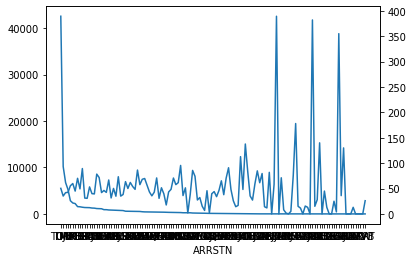

In [15]:
fig,ax = plt.subplots()
ax.plot(df_num_delay["number"])
ax.set_xlabel("ARRSTN")
ax2 = ax.twinx()
ax2.plot(df_num_delay["mean_delay"])
plt.show()

So: The great variation in delays for some destination is likely due to the small number of these destinations.

In [16]:
# weekday
df["STD_week_day"] = df["STD"].dt.weekday

In [17]:
# So there seems to be some dependence on the weekday
df.groupby("STD_week_day").mean()["target"]

STD_week_day
0    50.244653
1    38.501934
2    38.028904
3    45.605110
4    53.881395
5    53.408453
6    56.796620
Name: target, dtype: float64

In [18]:
df["STA"].dt.hour

0         12
1         16
2          6
3         17
4         15
          ..
107828     2
107829     9
107830    12
107831    18
107832     7
Name: STA, Length: 107833, dtype: int64

In [19]:
#pd.to_datetime("22")

In [20]:
# time of day: night morning. I will divide the day in to 2-hour intervals
bins = list(range(-1,24,2))
labels = range(0,24,2)
df["STD_hour_bin"] = pd.cut(df["STD"].dt.hour, bins=bins, labels=labels, include_lowest=True)
df["STD_hour"] = df["STD"].dt.hour
df.head(20)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,STD_week_day,STD_hour_bin,STD_hour
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,6,10,10
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2,14,15
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,5,4,4
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,6,14,14
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,6,14,14
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18:15:00,ATA,TU 736IOP,53.0,6,16,16
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09:00:00,ATA,TU 32AIMH,10.0,0,6,7
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09:55:00,ATA,TU 32AIMI,15.0,0,6,7
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09:00:00,ATA,TU 32AIMC,16.0,0,6,7
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09:15:00,ATA,TU 31AIMK,21.0,0,6,7


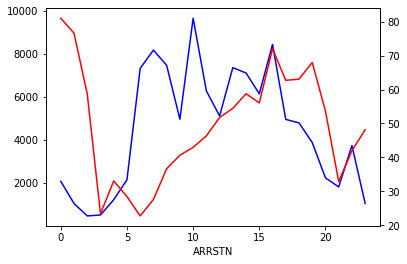

In [21]:
df_hour_delay = pd.DataFrame(df.groupby("STD_hour").count()["target"])
df_hour_delay.columns = ["number"]
df_hour_delay["mean_delay"] = df.groupby("STD_hour").mean()["target"]
#df_hour_delay.sort_values("number", ascending=False, inplace=True)
#df_hour_delay.head(5)

fig,ax = plt.subplots()
ax.plot(df_hour_delay["number"], color="b")
ax.set_xlabel("ARRSTN")
ax2 = ax.twinx()
ax2.plot(df_hour_delay["mean_delay"], color="r")
plt.show()

So: The time of day seems to influence the delay, although at night the number of flights are too low to have a good statistics.

### Holidays

In [22]:
holidays = pd.read_csv("data/holidays.csv", delimiter=", \t\t", engine='python')

In [23]:
holidays

,Day,Date,Holiday Name,Type,Comments
0,Friday,Jan 01 2016,New Year's Day,"National Holiday,",None
1,Thursday,Jan 14 2016,Revolution and Youth Day,"National Holiday,",None
2,Sunday,Mar 20 2016,Independence Day,National Holiday,National Day
3,Saturday,Apr 09 2016,Martyrs' Day,"National Holiday,",None
4,Sunday,May 01 2016,Labour Day,National Holiday,International Workers' Day
...,...,...,...,...,...
59,Tuesday,Aug 13 2019,Aïd El Kebir,National Holiday,Date varies on Lunar cycle
60,Wednesday,Aug 14 2019,Aïd El Kebir,National Holiday,Date varies on Lunar cycle
61,Sunday,Sep 01 2019,Ras el am el Hejri,National Holiday,Hijri New Year
62,Tuesday,Oct 15 2019,Evacuation Day,"National Holiday,",None


In [24]:
holidays["Date"] = pd.to_datetime(holidays["Date"], format="%b %d %Y")

In [ ]:
holidays_list = list(holidays["Date"].dt.date)
#holidays_list

In [26]:
from datetime import date, datetime, time, timedelta
holidays_list = sorted(holidays_list + [ x + timedelta(hours=24) for x in holidays_list] + [ x - timedelta(hours=24) for x in holidays_list])

In [27]:
df['around_holiday'] = df['STD'].dt.date.isin(holidays_list)

In [28]:
df.sort_values("DATOP").head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,STD_week_day,STD_hour_bin,STD_hour,around_holiday
4510,train_id_4510,2016-01-01,TU 0282,TUN,TLS,2016-01-01 07:30:00,2016-01-01 09:25:00,ATA,TU 736IOL,14.0,4,6,7,True
33327,train_id_33327,2016-01-01,UG 0009,DJE,TUN,2016-01-01 15:30:00,2016-01-01 16:30:00,SCH,UG AT7LBD,0.0,4,14,15,True
7179,train_id_7179,2016-01-01,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09:20:00,ATA,TU 736IOP,36.0,4,6,6,True
7180,train_id_7180,2016-01-01,TU 0251,NCE,MIR,2016-01-01 09:30:00,2016-01-01 11:15:00,ATA,TU 736IOR,0.0,4,8,9,True
7181,train_id_7181,2016-01-01,TU 0847,TUN,BEY,2016-01-01 09:30:00,2016-01-01 12:45:00,ATA,TU 320IMR,39.0,4,8,9,True


In [29]:
holidays['Date'].dt.date

0     2016-01-01
1     2016-01-14
2     2016-03-20
3     2016-04-09
4     2016-05-01
         ...    
59    2019-08-13
60    2019-08-14
61    2019-09-01
62    2019-10-15
63    2019-11-10
Name: Date, Length: 64, dtype: object

In [30]:
df.groupby('around_holiday').mean()

,target,STD_week_day,STD_hour
around_holiday,,,
False,48.042473,3.114339,12.118104
True,53.660204,3.201056,12.062995


The mean delay is a bit larger around the holiday. Maybe due to increased passenger counts.

### Flight length

In [108]:
df["flight_duration"] = df["STA"] - df["STD"]
df['flight_duration'] = df['flight_duration'].apply(lambda x : x.seconds)

In [101]:
8700/3600

2.4166666666666665

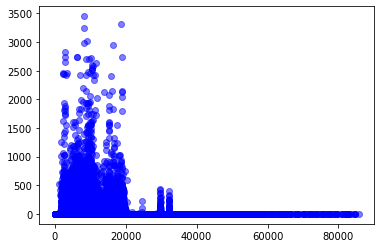

In [124]:
fig,ax = plt.subplots()
ax.scatter(df['flight_duration'], df['target'], color="b", alpha=0.5)
plt.show()

### Wind speed and other weather conditions as visibility
Source: https://www.wunderground.com/history/daily/de/frankfurt/EDDF/date/2015-3-18 \
web scrap from this website using a python script or similar

---
### Making a model

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
cols = df.columns.tolist()
cols.remove('target')
cols

['ID',
 'DATOP',
 'FLTID',
 'DEPSTN',
 'ARRSTN',
 'STD',
 'STA',
 'STATUS',
 'AC',
 'STD_week_day',
 'STD_hour_bin',
 'STD_hour',
 'around_holiday']

In [110]:
cols = ['DEPSTN', 'STD_week_day', 'STD_hour', 'around_holiday']
cols = ['STD_week_day', 'STD_hour', 'around_holiday']
cols = ['around_holiday']
cols = ['DEPSTN', 'STD_week_day', 'STD_hour', 'around_holiday', 'flight_duration']

In [111]:
df_cols = df[cols]

In [112]:
df_dummies = pd.get_dummies(df_cols, columns=['DEPSTN'])
#df_dummies = df_cols

In [113]:
df_dummies

,STD_week_day,STD_hour,around_holiday,flight_duration,DEPSTN_AAE,DEPSTN_AAL,DEPSTN_ABJ,DEPSTN_ADB,DEPSTN_AHU,DEPSTN_ALG,...,DEPSTN_TRN,DEPSTN_TUN,DEPSTN_VCE,DEPSTN_VIE,DEPSTN_VKO,DEPSTN_VNO,DEPSTN_VOG,DEPSTN_VRN,DEPSTN_YUL,DEPSTN_ZRH
0,6,10,False,8700,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,15,True,6600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,4,False,9300,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,6,14,False,10200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,14,False,4800,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,3,23,False,10800,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107829,5,8,True,3600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107830,2,5,False,28200,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107831,1,18,False,2700,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [114]:
df_dummies

,STD_week_day,STD_hour,around_holiday,flight_duration,DEPSTN_AAE,DEPSTN_AAL,DEPSTN_ABJ,DEPSTN_ADB,DEPSTN_AHU,DEPSTN_ALG,...,DEPSTN_TRN,DEPSTN_TUN,DEPSTN_VCE,DEPSTN_VIE,DEPSTN_VKO,DEPSTN_VNO,DEPSTN_VOG,DEPSTN_VRN,DEPSTN_YUL,DEPSTN_ZRH
0,6,10,False,8700,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,15,True,6600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,4,False,9300,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,6,14,False,10200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,14,False,4800,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,3,23,False,10800,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107829,5,8,True,3600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107830,2,5,False,28200,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
107831,1,18,False,2700,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [115]:
train_validate, test, train_validate_label, test_label = train_test_split(df_dummies, df['target'], test_size=0.2, random_state=RSEED) 

In [116]:
train, validate, train_label, validate_label = train_test_split(train_validate, train_validate_label, test_size=0.2, random_state=RSEED)

In [117]:
model = RandomForestRegressor(n_estimators=100, 
                              random_state=RSEED, 
                              max_features = 'sqrt', # The number of features to consider when looking for the best split:
                              n_jobs=-1, verbose = 1)

In [118]:
model.fit(train, train_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42,
                      verbose=1)

In [119]:
pred_val = model.predict(validate)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [120]:
rmse = mean_squared_error(pred_val, validate_label, squared=False)
rmse

113.13549741600444

In [84]:
pred_val

array([48.21820344, 48.21820344, 48.21820344, ..., 48.21820344,
       48.21820344, 48.21820344])

In [85]:
validate_label

27160      20.0
99443      50.0
6309       29.0
21851      11.0
82120       0.0
          ...  
36602       8.0
78629      26.0
107564      0.0
91094     342.0
91996      13.0
Name: target, Length: 17254, dtype: float64

/tmp/ipykernel_78787/3428523495.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


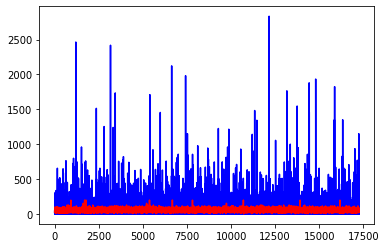

In [313]:
fig, ax = plt.subplots()
ax.plot(range(0,len(validate_label)),validate_label, color="b")
ax.plot(range(0,len(validate_label)),pred_val, color="r")
fig.show()

In [55]:
cols

['DEPSTN', 'STD_week_day', 'STD_hour', 'around_holiday']

### RMSE
\['STD_week_day', 'STD_hour', 'around_holiday'\]: 112.08316375746156
\['DEPSTN', 'STD_week_day', 'STD_hour', 'around_holiday'\]: 112.51484621961848



In [324]:
pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})


,A,B,C
0,a,b,1
1,b,a,2
2,a,c,3
